In [44]:
import pandas as pd
import numpy as np
pd.set_option("display.max_rows", 101)

1. Import confirmed, recovered and deaths data set for a given country

In [2]:
confirmed = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths = pd.read_csv('DATA/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

2. Pre-process the datasets

In [3]:
def reformat(df, country, col_name):
    
    df = df[df['Country/Region'] == country]
    index = df.iloc[0].name

    df = df.T
    df = df.rename({index: col_name}, axis = 1)
    # get rid of columns that do not represent the number of recovered/confirmed/deaths 
    df = df.iloc[4:,:]
    
    return df

    #df = df[df[col_name] > 0]


In [4]:
recovered = reformat(recovered, 'Switzerland', 'Recovered cases')
confirmed = reformat(confirmed, 'Switzerland', 'Confirmed cases')
deaths = reformat(deaths, 'Switzerland', 'Deaths cases')

recovered.tail()

,Recovered cases
4/26/20,21800
4/27/20,22200
4/28/20,22600
4/29/20,22600
4/30/20,23400


3. Create new data frame recovered per day so we know how many people recovered from the epidemic on a given day


**problem** : Here, I see that recovered_daily contains a negative value, therefore recovered is not fully incremental. ??? Change dataset?

In [5]:
recovered_daily = recovered.diff()
recovered_daily.iloc[0,:] = 0

In [6]:
deaths_daily = deaths.diff()
deaths_daily.iloc[0] = 0

4. Generate dataset infected representing the number of infected individuals at a given time t (not the new number of infected, number of actively infected individuals)

$$\text{confirmed}(t)=\text{confirmed}(t)-\sum_{i=\text{day}_0}^{t}\text{recovered_daily(i)}-\sum_{i=\text{day}_0}^{t}\text{deaths_daily}(i)$$

In [7]:
infected_ = []
days_ = []
# i: date (time t)
# row: row
acc_deaths = 0
acc_recovered = 0

for i, row in confirmed.iterrows():
    acc_recovered += recovered_daily.loc[i]['Recovered cases']
    acc_deaths += deaths_daily.loc[i]['Deaths cases']
    
    diff = row['Confirmed cases'] - acc_recovered - acc_deaths
    
    infected_.append(diff)
    days_.append(i)

Careful, infected represents active number of infected, not new number of infected

In [8]:
infected = pd.DataFrame({'Date': days_,'Infected Cases': infected_})

In [9]:
recovered = recovered.reset_index().rename({'index':'Date'}, axis = 1)

In [10]:
recovered.plot()

[Text(0.5, 0, 'Number of individuals recovered')]

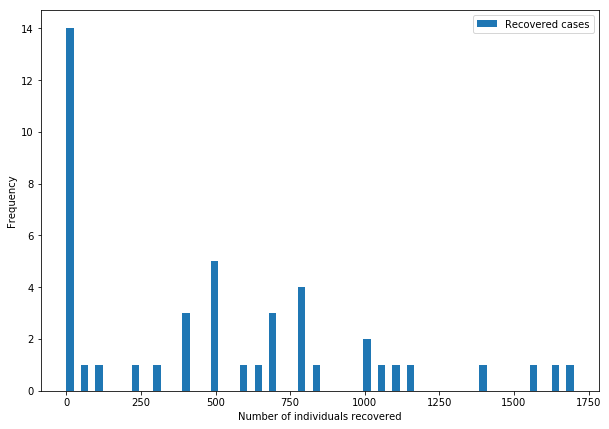

In [11]:
ax = pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot.hist(bins=70,figsize=(10,7))
ax.set(xlabel="Number of individuals recovered")
#pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot.hist(xlabel="Number of Recovered")
#(title="Frequency per number of daily recovered counted since 55th day (March 17th)")#.groupby()
# in order to see zeros from when people started recovering

[Text(0.5, 0, 'Day')]

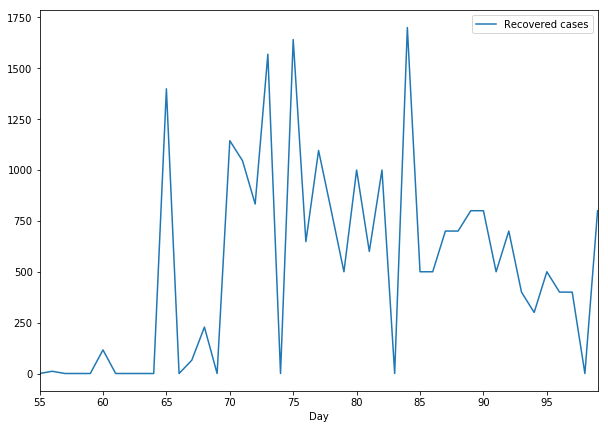

In [12]:
ax = pd.DataFrame(recovered['Recovered cases'].diff()).iloc[55:,:].plot(figsize=(10,7))
ax.set(xlabel='Day')

Now we can start working on predicting our gammas. 
Recovered is cumulative, as expected (absorbing state in our SIR model) and infected represents the number of infected individual at a certain date

In [13]:
data = recovered.merge(infected, on='Date')

In [14]:
data['Date'] = pd.to_datetime(data['Date'])
#df['DOB'] = pd.to_datetime(df.DOB)


In [15]:
data = data.set_index('Date')
data['Recovered Daily'] = recovered_daily
data.head()

,Recovered cases,Infected Cases,Recovered Daily
Date,,,
2020-01-22,0,0,0
2020-01-23,0,0,0
2020-01-24,0,0,0
2020-01-25,0,0,0
2020-01-26,0,0,0


In [16]:
data = data.reset_index()
data.tail()

,Date,Recovered cases,Infected Cases,Recovered Daily
95,2020-04-26,21800,5651,500
96,2020-04-27,22200,5299,400
97,2020-04-28,22600,4965,400
98,2020-04-29,22600,5091,0
99,2020-04-30,23400,4449,800


In [17]:
dataframe = pd.concat([data['Date'],data['Recovered Daily'], data['Infected Cases'].shift(7),
                   data['Infected Cases'].shift(8),data['Infected Cases'].shift(9),
                   data['Infected Cases'].shift(10),data['Infected Cases'].shift(11),
                   data['Infected Cases'].shift(12),data['Infected Cases'].shift(13),
                   data['Infected Cases'].shift(14),data['Infected Cases'].shift(15),
                   data['Infected Cases'].shift(16),data['Infected Cases'].shift(17),
                   data['Infected Cases'].shift(18),data['Infected Cases'].shift(19),
                   data['Infected Cases'].shift(20),data['Infected Cases'].shift(21)], axis=1)

To go on I think it would be better to have a larger data set

In [18]:
# create lagged dataset
dataframe.columns = ['Date', 'Recovered Daily', 'Infected cases t-7','Infected cases t-8','Infected cases t-9',
                    'Infected cases t-10','Infected cases t-11','Infected cases t-12','Infected cases t-13',
                    'Infected cases t-14','Infected cases t-15','Infected cases t-16','Infected cases t-17',
                    'Infected cases t-18','Infected cases t-19','Infected cases t-20','Infected cases t-21']

# Keep data such that we have value t-21 at any given day t
dataframe = dataframe[~np.isnan(dataframe['Infected cases t-21'])]



In [19]:
dataframe = dataframe.set_index('Date')

### Delete first 15 days (noise data)

In [20]:
dataframe_new = dataframe.iloc[15:,:].copy()

In [61]:
y = dataframe_new['Recovered Daily']
X = dataframe_new.iloc[:,1:]

In [23]:
type(X)

numpy.ndarray

In [24]:
dataframe_new

,Recovered Daily,Infected cases t-7,Infected cases t-8,Infected cases t-9,Infected cases t-10,Infected cases t-11,Infected cases t-12,Infected cases t-13,Infected cases t-14,Infected cases t-15,Infected cases t-16,Infected cases t-17,Infected cases t-18,Infected cases t-19,Infected cases t-20,Infected cases t-21
Date,,,,,,,,,,,,,,,,
2020-02-27,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-28,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-01,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-02,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-03,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-04,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-05,0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-06,0,8.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Apply changes on Dataframe when recovered value equals 0

In [25]:
df = dataframe_new.copy()

In [70]:
# don't forget to round up
recovered = df['Recovered Daily'].reset_index()

for i, el in recovered.iterrows():
    if (i > 24) & (el['Recovered Daily'] == 0):
        mean = round(recovered.iloc[i+1,1]/2)
        print(i,mean)
        recovered.iloc[i,1] = mean
        recovered.iloc[i+1, 1] = mean
            #acc.append(mean)
            #acc.append(mean)



25 0.0
26 0.0
27 0.0
28 700.0
30 32.0
33 572.0
38 820.0
47 850.0
62 400.0


In [80]:
y_smoothed = recovered.set_index('Date').rename({'Recovered Daily': 'Recovered Daily Smoothed'}, axis=1)

In [81]:
data = pd.concat([X, y, y_smoothed], axis=1)

In [82]:
data.to_csv('data.csv')